# Surf Check

## Imports

In [1]:
import os
from datetime import datetime, timedelta
import pytz
import json
import csv
import pandas as pd
import numpy as np
import requests
# Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D # legend
import matplotlib.dates as mdates # date formatting
# Arrow marker
from matplotlib.transforms import Affine2D
from matplotlib.path import Path

## INPUTS (from config, directions, arrow) 

In [2]:
# get config
parent_folder = os.path.dirname(os.path.realpath("__file__"))
with open(f"{parent_folder}/config.json") as file:
  config = json.load(file)

# get current time
tz = pytz.timezone(config["tz"])
currentTime = tz.localize(datetime.now()).replace(tzinfo=None)

# get domain times
startTime = currentTime - timedelta(hours=config["hours_trailing"]) 
finishTime = currentTime + timedelta(hours=config["hours_leading"])

# gets directionDict. A dict with 
#   key   : direction symbol e.g. "NW" 
#   value : bearing of direction to between -180 < value <= 180. e.g. "NW" is -45
with open(f"{parent_folder}/directions.json") as file:
  directionDict = json.load(file)

# gets arrowUp
with open(f"{parent_folder}/arrow.csv") as file:
  vertices = np.loadtxt(file, delimiter=",")
codes = [Path.MOVETO] + [Path.LINETO] * (len(vertices) - 2) + [Path.CLOSEPOLY]
arrowDown = Path(vertices, codes) # upward pointing arrow that will later be rotated

## Data Source Methods

In [3]:
def getData():
  # data for wind/swell obswervation/forecast day/night
  data = {}
  data['WindObservation'] = getObservationWind()
  data['WindForecast'] = getForecastWind()
  data['SwellObservation'], data['SwellForecast'] = getSwell()
  data['light_zones'] = getDaylight()
  return data

In [4]:
def knotsToKmph(knots):
  return knots * 1.852 # 1 knot is 1.852 km/h

In [5]:
def getObservationWind():
  # from http://www.bom.gov.au/products/IDN60801/IDN60801.95745.shtml#other_formats under JSON link
  response = requests.get(
    "http://www.bom.gov.au/fwo/IDN60701/IDN60701.95745.json",
    headers={"User-Agent": "Mozilla/5.0"}
  )
  if not response.ok:
    print(f"ERROR getObservationWind request is bad. status={response.status_code}")
    return 
  data = response.json() 
  dataList = data["observations"]["data"][::-1]

  dates = []
  speeds = []
  directions = []
  for pnt in dataList:
    date = datetime.strptime(pnt["local_date_time_full"], "%Y%m%d%H%M%S")
    if(startTime <= date and date <= finishTime):
      dates.append(date)
      speeds.append(knotsToKmph(pnt["wind_spd_kt"]))
      directions.append(directionDict[pnt["wind_dir"]])
  return pd.DataFrame(
    {
      "speed": speeds, 
      "direction": directions
    }, 
    index=dates
  )

In [6]:
# df = getObservationWind()
# print(df)

In [7]:
def getForecastWind():
  # from https://github.com/tonyallan/weather-au use the first two links under 'Weather API'
  response = requests.get(
    "https://api.weather.bom.gov.au/v1/locations/r3g7cg/forecasts/3-hourly"
  )
  if not response.ok:
    print(f"ERROR getForecastWind request is bad. status={response.status_code}")
    return
  data = response.json() 
  dataList = data['data'][::-1]

  dates = []
  speeds = []
  directions = []
  for pnt in dataList:
    date = datetime.strptime(pnt["time"][:19], "%Y-%m-%dT%H:%M:%S")
    if(currentTime <= date and date <= finishTime):
      dates.append(date)
      speeds.append(pnt['wind']['speed_kilometre'])
      directions.append(directionDict[pnt['wind']['direction']])
  return pd.DataFrame(
    {
      "speed": speeds, 
      "direction": directions}, 
    index=dates
  )

In [8]:
# df = getForecastWind()
# print(df)

In [9]:
def getSwell():
  response = requests.get('https://forecast.waves.nsw.gov.au',
    params={
      "page": 'series',
      "id": config['swell_location_id'] # 3000876 is port kembla main beach @30m depth
    }
  )
  itemList = response.text.split("\n")
  
  datesObserved = []
  datesForecast = []
  hsms = [] # Nearshore significant wave height tranformation from measured (m)
  dirms = [] # Nearshore wave direction transformation from measured (° TNorth)
  hsfs = [] # Same as hsms but forecast
  dirfs = [] # Same as dirms but forecast
  itemList.pop(0) # pops heading: Date,Hsm,Tpm,Dirm,Hsf,Tpf,Dirf
  for x in itemList: 
    row = x.split(",")
    if len(row) != 7:
      continue
    date, hsm, tpm, dirm, hsf, tpf, dirf = row
    date = datetime.strptime(date[:19], "%Y-%m-%d %H:%M:%S")
    if date < startTime:
      continue
    elif date > finishTime:
      break
    if date <= currentTime and hsm != '':
      datesObserved.append(date)
      hsms.append(float(hsm))
      dirms.append(float(dirm))
    if date > currentTime and hsf != '':
      datesForecast.append(date)
      hsfs.append(float(hsf))
      dirfs.append(float(dirf))
  dfObserved = pd.DataFrame(
    {
      "height": hsms, 
      "direction": dirms
    }, 
    index=datesObserved
  )
  dfForecast = pd.DataFrame(
    {
      "height": hsfs, 
      "direction": dirfs
    }, 
    index=datesForecast
  )
  return dfObserved, dfForecast

In [10]:
# df1, df2 = getSwell()
# print(df1)
# print(df2)

In [11]:
def isBeforeTime(date, hour, minute):
  return (date.hour < hour) or (date.hour == hour and date.minute < minute)

In [12]:
def getDaylight():
  color_day = '#FFFA4F' # day yellow colour for da sun
  color_night = '#7733FF' # puple night colour
  color_current = 'c' # cyan color to indicate the current time. Included in last df row
  
  # Thanks to the devs at Sunrise - Sunset. See https://sunrise-sunset.org/api
  response = requests.get(
    "https://api.sunrise-sunset.org/json",
    params={
      "lat": config["lat"],
      "lng": config["lng"],
      "formatted": 0
    }
  )
  data = response.json() 
  
  # civil_twilight_begin/civil_twilight_end is civil_dawn/civil_dusk or firstlight/lastlight
  # civil_dawn/civil_dusk is rougly the time needed where 
  # artificial light should be used for outdoor activities
  datetimeFromStr = lambda s : datetime.strptime(s[:19], "%Y-%m-%dT%H:%M:%S")
  firstLightRaw = pytz.utc.localize(datetimeFromStr(data['results']['civil_twilight_begin']))
  lastLightRaw = pytz.utc.localize(datetimeFromStr(data['results']['civil_twilight_end']))
  firstLight = firstLightRaw.astimezone(tz).replace(tzinfo=None)
  lastLight = lastLightRaw.astimezone(tz).replace(tzinfo=None)
  fL_hour = firstLight.hour
  fL_min = firstLight.minute
  lL_hour = lastLight.hour
  lL_min = lastLight.minute
  day_delta = lastLight - firstLight
  night_delta = timedelta(hours=24) - day_delta
  
  def nextZones(start, isDay):
    while start < finishTime:
      if isDay:
        light_zones.append([start, start + day_delta, color_day])
        start += day_delta
      else:
        light_zones.append([start, start + night_delta, color_night])
        start += night_delta
      isDay = not isDay
    return light_zones
  
  light_zones = []
  firstTime = startTime # first time before start where day/night transition occurs
  if ((not isBeforeTime(startTime, fL_hour, fL_min)) and isBeforeTime(startTime, lL_hour, lL_min)): 
    # start is day zone
    start = startTime.replace(hour=fL_hour, minute=fL_min)
    light_zones.append([start, start + day_delta, color_day])
    # next zones
    start += day_delta 
    isDay = False
    light_zones = nextZones(start, isDay)
  else:
    # start is night zone
    if((not isBeforeTime(startTime, lL_hour, lL_min)) and isBeforeTime(startTime, 24, 0)): 
      # start is arvo night zone
      firstTime = startTime.replace(hour=lL_hour, minute=lL_min)
    else: 
      # start is early hours night zone
      firstTime = startTime - timedelta(hours=fL_hour, minutes=fL_min)
      firstTime = firstTime.replace(hour=lL_hour, minute=lL_min)
    start = firstTime
    light_zones.append([start, start + night_delta, color_night])
    # next zones
    start += night_delta 
    isDay = True
    light_zones = nextZones(start, isDay)
      
  current_delta = timedelta(minutes=5)
  light_zones.append([currentTime - current_delta, currentTime + current_delta, color_current])
  return light_zones

In [13]:
# light_zones = getDaylight()
# print(light_zones)

In [14]:
data = getData()

## Graph Methods

In [15]:
def getMaxSpeed(data):
  extraSpace = 5 # range between top speed and top of plot if over smallestMax 
  maxSpeed = 50 # plot shows up to at least 50km/h
  if not data['WindObservation'].empty:
    _speed = max(data['WindObservation']['speed']) + extraSpace
    if _speed > maxSpeed:
      maxSpeed = speed
  if not data['WindForecast'].empty:
    _speed = max(data['WindForecast']['speed']) + extraSpace
    if _speed > maxSpeed:
      maxSpeed = speed
  return maxSpeed

In [16]:
def getMaxHeight(data):
  extraSpace = 1 # range between top height and top of plot if over smallestMax 
  maxHeight = 3 # plot shows up to at least 3m
  if not data['SwellObservation'].empty:
    _height = max(data['SwellObservation']['height']) + extraSpace
    if _height > maxHeight:
      maxHeight = _height
  if not data['SwellForecast'].empty:
    _height = max(data['SwellForecast']['height']) + extraSpace
    if _height > maxHeight:
      maxHeight = _height
  return maxHeight

In [17]:
def plotDFlineMarker(ax, df, valuesColumn, color):
  # plots the line and arrow markers for each dataframe
  if df.empty:
    return
  ax.plot(df.index, df[valuesColumn], c=color) # line between points
  for i, angleTo in enumerate(df['direction']):
    arrow = arrowDown.transformed(Affine2D().rotate_deg(-angleTo))
    ax.plot(df.index[i], df[valuesColumn][i], color, marker=arrow, markersize=10)

In [18]:
def graph(data):
  # formatting
  fig, axes = plt.subplots(2, figsize=(10, 4.5), sharex=True)
  fig.suptitle('Surf Check: Port Kembla', size='x-large')
  plt.subplots_adjust(top=0.85, bottom=-0.1) # space for title and legend
  for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%l:%M %p'))
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 2)))
    ax.tick_params(bottom=False)
    ax.grid(axis='x', color=(0.4, 0.4, 0.4))
    for lightStart, lightFinish, lightColor in data['light_zones']: # Daylight plotting
      ax.axvspan(lightStart, lightFinish, facecolor=lightColor, alpha=0.5)
  plt.xticks(rotation=45, ha='right')
  plt.xlim(startTime, finishTime)

  # legend
  legend_elements = [
    Line2D([0], [0], color='b', lw=4, label='Observed'),
    Line2D([0], [0], color='r', lw=4, label='Forecast'),
    Line2D([], [], color='#1f77b4', marker='|', linestyle='None',
      markersize=10, markeredgewidth=4, label='Current time')
  ]
  plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0, -0.6, 1, 0.2), 
    mode="expand", ncol=3) # plot outside chart

  # Wind Subplot
  ax_wind = axes[0]
  ax_wind.set_title('Wind Speed (km/h)')
  ax_wind.set_ylim(-1, getMaxSpeed(data))
  plotDFlineMarker(ax_wind, data['WindObservation'], 'speed', 'b')
  plotDFlineMarker(ax_wind, data['WindForecast'], 'speed', 'r')
  
  # Swell Subplot
  ax_swell = axes[1]
  ax_swell.set_title('Swell Height (m)')
  ax_swell.set_ylim(-0.1, getMaxHeight(data))
  plotDFlineMarker(ax_swell, data['SwellObservation'], 'height', 'b')
  plotDFlineMarker(ax_swell, data['SwellForecast'], 'height', 'r')

  plt.show()

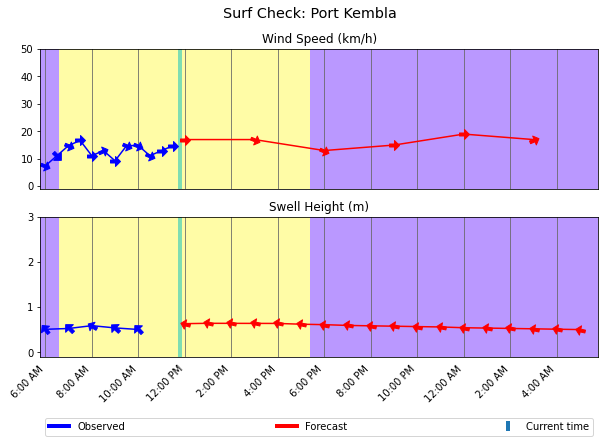

In [19]:
graph(data)